In [16]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from applefy.utils.file_handling import save_as_fits, open_fits, load_adi_data

# All folders of interest

In [2]:
rood_result_dir = Path("/fast/mbonse/NACO/70_results/")

In [3]:
dataset_result_dir = rood_result_dir / Path("HD124553_167_089_C-0641_A")

# 1.) Define all subtasks based on result folders

## 1.1 Read S4 results

In [4]:
def get_s4_residuals(dataset_result_dir):

    tmp_s4_results_dir = dataset_result_dir / Path("S4/residuals/")

    mean_residuals = []
    median_residuals = []

    for tmp_lambda_dir in sorted(list(tmp_s4_results_dir.iterdir())):
        tmp_lambda = int(tmp_lambda_dir.name.split("_")[1])
        
        mean_file = tmp_lambda_dir / Path("Residual_Mean_epoch_0500.fits")
        median_file = tmp_lambda_dir / Path("Residual_Median_epoch_0500.fits")
        if (not mean_file.is_file()) or (not median_file.is_file()):
            continue 
            
        mean_residual = open_fits(mean_file)
        median_residual = open_fits(median_file)
        mean_residuals.append(mean_residual)
        median_residuals.append(median_residual)

    mean_residuals = np.array(mean_residuals)[::-1]
    median_residuals = np.array(median_residuals)[::-1]

    return np.array([mean_residuals, median_residuals])

In [5]:
residuals = get_s4_residuals(rood_result_dir / Path("ELIA2-24_197_0101_C-0466_A/"))

In [6]:
residuals.shape

(2, 9, 119, 119)

## 1.2 Read PCA residuals

In [7]:
pca_selection = np.array([
    1, 2, 4, 6, 8, 10, 15, 20, 25,
    30, 35, 40, 45, 50, 60, 70, 
    80, 90, 100, 125, 150, 175, 200, 
    250, 300, 350, 400, 450, 500]) - 1

def get_pca_residuals(dataset_result_dir):
    tmp_pca_results_dir = dataset_result_dir / Path("PCA/pca_residuals.fits")
    
    pca_residuals = open_fits(tmp_pca_results_dir)
    return pca_residuals[:, pca_selection, :, :]

In [8]:
pca_residuals = get_pca_residuals(dataset_result_dir)

In [9]:
pca_residuals.shape

(2, 29, 165, 165)

## 1.3 Plot PSF template and science frame

In [10]:
raw_data_dir = Path("/fast/mbonse/NACO/30_data/")

In [11]:
def plot_science_frames(dataset_result_dir, output_dir):
    tmp_dataset = raw_data_dir / Path(dataset_result_dir.name + "_sel.hdf5")
    
    if not tmp_dataset.is_file():
        print("Dataset " + str(tmp_dataset) + " not found.")
        return
    
    # Load the data
    science_data, _, raw_psf_template_data = load_adi_data(
        str(tmp_dataset),
        data_tag="object_hr_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_hr_stacked_05/PARANG")
    
    mean_science = np.mean(science_data, axis=0)
    psf_template = np.median(raw_psf_template_data, axis=0)
    
    # Create the plot
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
        3, 2, figsize=(8,9), height_ratios=[1, 1, 0.3])

    ax1.imshow(mean_science, norm="log")
    ax1.axis("off")
    ax1.set_title("Science Average (log)", size=14)

    ax2.imshow(mean_science)
    ax2.axis("off")
    ax2.set_title("Science Average", size=14)

    ax3.imshow(science_data[0], norm="log")
    ax3.axis("off")
    ax3.set_title("Example science frames (log)", size=14)

    ax4.imshow(psf_template)
    ax4.axis("off")
    ax4.set_title("Unsaturated PSF", size=14)
    
    
    # plot 1D profiles
    mid_point = int(mean_science.shape[0] / 2 - 0.5)
    ax5.plot(mean_science[mid_point, :])
    ax5.plot(mean_science[:, mid_point])
    ax5.vlines([mid_point, ], 0, 1.1 * np.max(mean_science[:, mid_point]),
               label="Frame Center")
    ax5.set_xlim(mid_point - 15, mid_point + 15)
    ax5.set_ylim(0, 1.1 * np.max(mean_science[:, mid_point]))
    ax5.set_title("1D cut Science Frame")
    
    
    mid_point = int(psf_template.shape[0] / 2 - 0.5)
    ax6.plot(psf_template[mid_point, :])
    ax6.plot(psf_template[:, mid_point])
    ax6.vlines([mid_point, ], 0, 1.1 * np.max(psf_template[:, mid_point]),
               label="Frame Center")
    ax6.set_xlim(mid_point - 15, mid_point + 15)
    ax6.set_ylim(0, 1.1 * np.max(psf_template[:, mid_point]))
    ax6.set_title("1D cut PSF template")

    plt.tight_layout()
    
    # save the plot 
    result_file = output_dir / Path("science_frames.png")
    _=plt.savefig(result_file)
    
    return science_data.shape[0]

4733

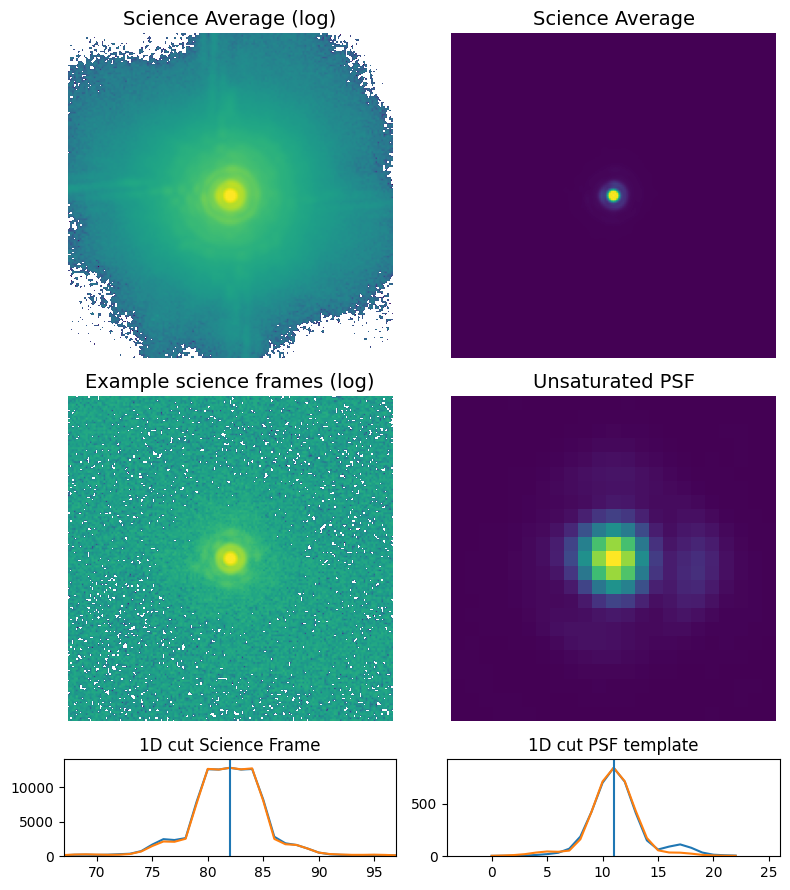

In [12]:
plot_science_frames(dataset_result_dir, ".")

# 2.) Copy all results

In [13]:
rood_result_dir = Path("/fast/mbonse/NACO/70_results/")
raw_data_dir = Path("/fast/mbonse/NACO/30_data/")
output_dir = Path("/fast/tgebhard/catnip/data/")

In [ ]:
for dataset_result_dir in rood_result_dir.iterdir():
    print(dataset_result_dir.name)
    
    # 1.) Create the output dir
    tmp_output_dir = output_dir / Path(dataset_result_dir.name)
    tmp_output_dir.mkdir(exist_ok=True)
    
    # 2.) Get the residuals
    try:
        s4_residual = get_s4_residuals(dataset_result_dir)
        
        # S4.) save the mean
        s4_out_file_mean = tmp_output_dir / Path("S4_residuals_mean.fits")
        
        if not s4_out_file_mean.is_file():
            save_as_fits(s4_residual[0], s4_out_file_mean)
        else:
            print(str(s4_out_file_mean) + " exists already...")
            
        # S4.) save the median
        s4_out_file_median = tmp_output_dir / Path("S4_residuals_median.fits")
        
        if not s4_out_file_median.is_file():
            save_as_fits(s4_residual[1], s4_out_file_median)
        else:
            print(str(s4_out_file_median) + " exists already...")

        # 3.) Get the PCA residuals
        pca_residual = get_pca_residuals(dataset_result_dir)
        
        # PCA Mean
        pca_out_file_mean = tmp_output_dir / Path("PCA_residuals_mean.fits")
        if not pca_out_file_mean.is_file():
            save_as_fits(pca_residual[0], pca_out_file_mean)
        else:
            print(str(pca_out_file_mean) + " exists already...")
        
        # PCA Median
        pca_out_file_median = tmp_output_dir / Path("PCA_residuals_median.fits")
        if not pca_out_file_median.is_file():
            save_as_fits(pca_residual[1], pca_out_file_median)
        else:
            print(str(pca_out_file_median) + " exists already...")
            
    except:
        print("PROBLEM WITH: " + str(dataset_result_dir))
    
    # 4.) Plot the science data
    #num_science_frames = plot_science_frames(dataset_result_dir, tmp_output_dir)
    
    # 5.) Save some basic information
    #data_dict = {}
    #data_dict["num_stacked_frames"] = num_science_frames
    #with open(tmp_output_dir / Path('meta_information.json'), 'w', encoding='utf-8') as f:
        #json.dump(data_dict, f, ensure_ascii=False, indent=4)

GAIA-DR3-4719926581631285248_246_1101_C-0092_B
/fast/tgebhard/catnip/data/GAIA-DR3-4719926581631285248_246_1101_C-0092_B/S4_residuals_mean.fits exists already...
/fast/tgebhard/catnip/data/GAIA-DR3-4719926581631285248_246_1101_C-0092_B/S4_residuals_median.fits exists already...
/fast/tgebhard/catnip/data/GAIA-DR3-4719926581631285248_246_1101_C-0092_B/PCA_residuals_mean.fits exists already...
/fast/tgebhard/catnip/data/GAIA-DR3-4719926581631285248_246_1101_C-0092_B/PCA_residuals_median.fits exists already...
HD131835_125_097_C-0206_A
/fast/tgebhard/catnip/data/HD131835_125_097_C-0206_A/S4_residuals_mean.fits exists already...
/fast/tgebhard/catnip/data/HD131835_125_097_C-0206_A/S4_residuals_median.fits exists already...
/fast/tgebhard/catnip/data/HD131835_125_097_C-0206_A/PCA_residuals_mean.fits exists already...
/fast/tgebhard/catnip/data/HD131835_125_097_C-0206_A/PCA_residuals_median.fits exists already...
GAIA-DR3-4326511906643771904_151_0103_C-0290_A
/fast/tgebhard/catnip/data/GAIA-

HD95086_22_094_C-0052_B
HD39060_271_086_C-0341_B
HD164249_211_087_C-0292_A
ELIA2-27_139_199_C-0065_A
HD135344B_83_090_C-0443_B
GJ1054A_260_097_C-0972_A
HD361_165_089_C-0641_A
HD186219_144_1101_C-0092_E
HD32195_309_088_C-0085_A
PDS70_189_1101_C-0092_G
HD11397_234_091_C-0721_B
HD169142_138_199_C-0065_A
HD191089_215_097_C-0206_B
HD90905_102_1101_C-0092_E
GJ281_353_086_C-0164_A
HD143006_157_1101_C-0092_A
HD68146_354_086_C-0164_A
HD223352_202_1101_C-0092_B
GAIA-DR3-6080177569354209024_153_097_C-0206_A
HD216956_243_087_C-0450_B
HD100546_75_198_C-0612_B
HD1461_293_1101_C-0092_C
HD35114_331_1101_C-0092_C
HD134888_124_199_C-0065_A


In [ ]:
print("a")